# Baseline 

#### Using the following paper: https://journals.sagepub.com/doi/epub/10.5772/56884

#### Imports

In [1]:
import cv2
from scipy.signal import medfilt
from scipy import ndimage
import numpy as np
import os
from matplotlib import pyplot as plt
from ipyfilechooser import FileChooser
from multiprocessing import Pool
from sklearn.cluster import MeanShift, estimate_bandwidth

### File Chooser

In [3]:
# Create and display a FileChooser widget
fc = FileChooser('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Data\\dataset')
display(fc)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset', filename='', title='', show_hidden=False…

#### Main Algorithm

### Mean Shift Segmentation Approach

In [2]:
def mean_shift(filename): 
    img = cv2.imread(filename)

    # filter to reduce noise
    img = cv2.medianBlur(img, 3)

    # flatten the image
    flat_image = img.reshape((-1,3))
    flat_image = np.float32(flat_image)

    # meanshift
    bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
    ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
    ms.fit(flat_image)
    labeled=ms.labels_

    # get number of segments
    segments = np.unique(labeled)
    print('Number of segments: ', segments.shape[0])

    # get the average color of each segment
    total = np.zeros((segments.shape[0], 3), dtype=float)
    count = np.zeros(total.shape, dtype=float)
    for i, label in enumerate(labeled):
        total[label] = total[label] + flat_image[i]
        count[label] += 1
    avg = total/count
    avg = np.uint8(avg)

    # cast the labeled image into the corresponding average color
    res = avg[labeled]
    result = res.reshape((img.shape))

    # Define the range of blue color in LAB color space
    lower_blue = np.array([0, 0, 0])
    upper_blue = np.array([255, 128, 255])

    # Create a mask for the sky
    mask = cv2.inRange(result, lower_blue, upper_blue)

    # Invert the mask
    mask = 255 - mask
    mask = (mask / 255).astype(np.uint8)

    # Apply the mask to the original image
    after_img = cv2.bitwise_and(img, img, mask=mask)

    # save the image
    #cv2.imwrite('output\\result_' + filename.split("\\")[-2] + '_' + filename.split("\\")[-1] + '.jpg', after_img)
    #cv2.imwrite('output\\original_' + filename.split("\\")[-2] + '_' + filename.split("\\")[-1] + '.jpg', img)

    return after_img, mask
    

#### Display Results and save them

In [3]:
def display_results(filename): 
    print("Processing: " + filename.split("\\")[-2] + " - " + filename.split("\\")[-1])

    after_img, mask = mean_shift(filename)
    val_image = cv2.imread("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Data\\dataset\\ValidationImages\\Skyfinder\\" + filename.split("\\")[-2] + ".png")
    #cv2.imshow('result',after_img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    #calculate the precision and recall between val_image and mask
    val_image = cv2.cvtColor(val_image, cv2.COLOR_BGR2GRAY)
    val_image = cv2.resize(val_image, (mask.shape[1], mask.shape[0]))

    #calculate the precision and recall
    true_pos = np.sum(np.logical_and(val_image, mask))
    false_pos = np.sum(np.logical_and(np.logical_not(val_image), mask))
    false_neg = np.sum(np.logical_and(val_image, np.logical_not(mask)))

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = 2 * (precision * recall) / (precision + recall)

    #print("Precision: " + str(precision))
    #print("Recall: " + str(recall))
    #print("F1: " + str(f1))

    return [precision, recall, f1, filename]


### Data for random 100 images

Processing: 10066 - 20130302_132736.jpg
Number of segments:  13
Processing: 8733 - 20130511_133640.jpg
Number of segments:  8
Processing: 10066 - 20131024_075728.jpg
Number of segments:  68
Processing: 9730 - 20130426_152708.jpg
Number of segments:  7
Processing: 3396 - 20130824_073848.jpg
Number of segments:  8
Processing: 7371 - 20120917_101727.jpg
Number of segments:  9
Processing: 3837 - 20130212_152218.jpg
Number of segments:  13
Processing: 65 - 20131102_210303.jpg
Number of segments:  6
Processing: 19306 - 20130606_182323.jpg
Number of segments:  9
Processing: 260 - 20130710_161501.jpg
Number of segments:  11
Processing: 684 - 20121218_171156.jpg
Number of segments:  12
Processing: 260 - 20131120_194454.jpg
Number of segments:  27
Processing: 4801 - 20110811_201003.jpg
Number of segments:  8
Processing: 3888 - 20131228_114221.jpg
Number of segments:  8
Processing: 1093 - 20140802_195401.jpg
Number of segments:  22
Processing: 7371 - 20121109_101727.jpg
Number of segments:  6
Pro

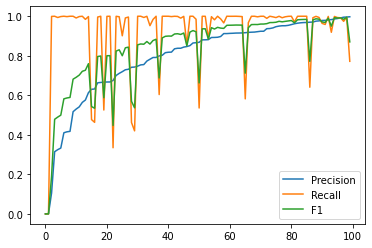

Precision: 0.00017210519069255127
Recall: 2.0958736439697525e-05
F1: 3.73669735740763e-05
Filename: C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset\OriginalImages\19306\20130606_182323.jpg


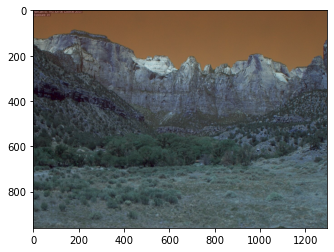

Precision: 0.0008763729843421361
Recall: 0.00012575241863818515
F1: 0.00021994457396736026
Filename: C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset\OriginalImages\19306\20130218_165333.jpg


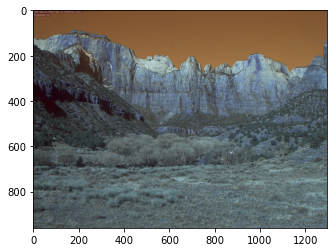

Precision: 0.10561139133825583
Recall: 0.9991669641794597
F1: 0.19103092079816159
Filename: C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset\OriginalImages\4795\20121225_130424.jpg


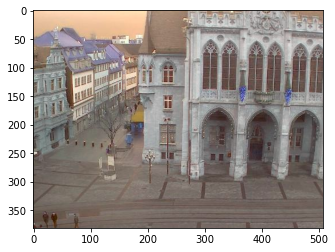

Precision: 0.31466508552537015
Recall: 0.9999429028206006
F1: 0.47869345360120275
Filename: C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset\OriginalImages\3888\20130109_111350.jpg


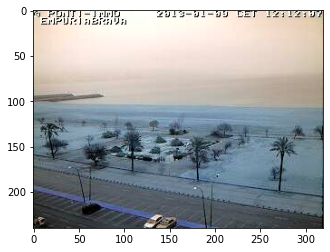

Precision: 0.32502848178099847
Recall: 0.9936622130866736
F1: 0.4898321066186302
Filename: C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset\OriginalImages\3888\20130227_144230.jpg


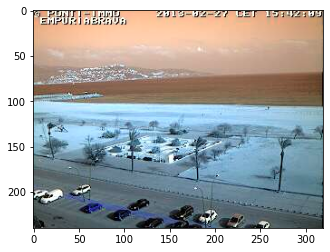

Precision: 0.33313556657640386
Recall: 0.9984042553191489
F1: 0.4995779499775667
Filename: C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset\OriginalImages\3837\20130212_152218.jpg


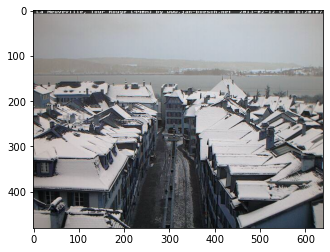

Precision: 0.4105712039449583
Recall: 1.0
F1: 0.5821346739486951
Filename: C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset\OriginalImages\7211\20120219_123951.jpg


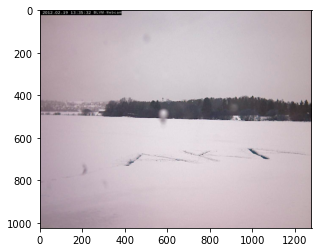

Precision: 0.41533563682986724
Recall: 0.9980482901324421
F1: 0.586571014798546
Filename: C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset\OriginalImages\7233\20130529_070146.jpg


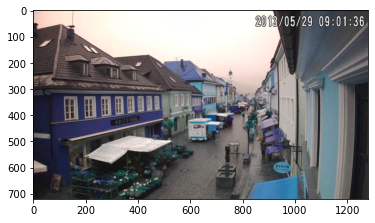

Precision: 0.4177236924540755
Recall: 1.0
F1: 0.5892878770065513
Filename: C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset\OriginalImages\7211\20120131_083958.jpg


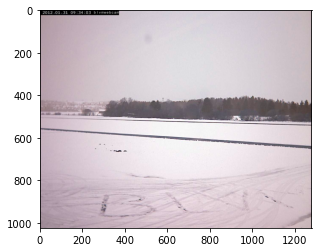

Precision: 0.5170347189418989
Recall: 0.9999429028206006
F1: 0.6816253454248238
Filename: C:\Users\cjbla\OneDrive\Desktop\Code\Data\dataset\OriginalImages\3888\20130314_084352.jpg


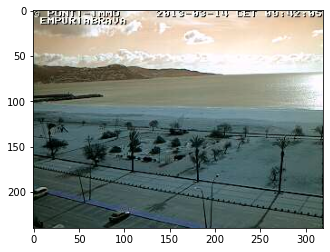

In [4]:
acc = []
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Data\\dataset\\OriginalImages") for f in filenames if os.path.splitext(f)[1] == '.jpg']

random = [np.random.randint(0, len(files)) for i in range(0, 100)]
for i in random:
    acc.append(display_results(files[i]))

print("Average Precision: " + str(np.mean([i[0] for i in acc])))
print("Average Recall: " + str(np.mean([i[1] for i in acc])))
print("Average F1: " + str(np.mean([i[2] for i in acc])))

#sort acc
acc.sort(key=lambda x: x[0])

#display the results in a graph
plt.plot([i[0] for i in acc], label="Precision")
plt.plot([i[1] for i in acc], label="Recall")
plt.plot([i[2] for i in acc], label="F1")
plt.legend()
plt.show()

#display the worst 10 results
for i in range(0, 10):
    print("Precision: " + str(acc[i][0]))
    print("Recall: " + str(acc[i][1]))
    print("F1: " + str(acc[i][2]))
    print("Filename: " + acc[i][3])
    img = cv2.imread(acc[i][3])
    plt.imshow(img)
    plt.show()


# Deep Learning Methodology

Desigining a model and input pipeline for the data

### Imports

In [4]:
#load the dataset
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
#import keras
#from keras.models import Model
#from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
#from keras.layers import  Dropout, Activation
#from keras.optimizers import Adam, SGD
#from keras.layers.advanced_activations import LeakyReLU
#from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#from keras import backend as K
#from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import pandas as pd
#dataset = tf.data.Dataset.load("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\SkyDataset")

### Input Pipeline

Only run to create the dataset

In [5]:
#set tensorflow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

#create a function that imports image_paths.csv and converts it into a tf.data.Dataset
def get_dataset(image_paths, label_paths):

    def _parse_function(image_path, label_path):

        image_string = tf.io.read_file(image_path)
        label_string = tf.io.read_file(label_path)

        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        label_decoded = tf.image.decode_png(label_string, channels=1)

        image_decoded = tf.cast(image_decoded, tf.int32)
        label_decoded = tf.where(label_decoded > 0, 1, 0)
        return image_decoded, label_decoded

    epoch_size = len(image_paths)
    image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
    label_paths = tf.convert_to_tensor(label_paths, dtype=tf.string)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(_parse_function, num_parallel_calls=8)

    return dataset

#import image_paths.csv into a dataframe
df = pd.read_csv("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\image_paths.csv")
image_paths = df["image_path"].tolist()
label_paths = df["label"].tolist()

#load the dataset
dataset = get_dataset(image_paths, label_paths)

#shuffle dataset
dataset = dataset.shuffle(10000)

#split the dataset into train and test
test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)

#print the length of the dataset
print(len(dataset))

#save the dataset as a file
#tf.data.Dataset.save(dataset, "C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\SkyDataset")

38115


(480, 640, 3)


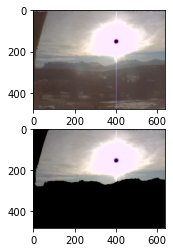

In [6]:
#print first 5 images in the dataset
for image, label in dataset.take(1):
    #mask the image with the label
    image_masked = image * label # type: ignore

    print(image_masked.shape)

    plt.figure(1)
    plt.subplot(2,1,1)
    plt.imshow(image)
    #plt.subplot(2,1,2)
    #plt.imshow(label)
    plt.subplot(2,1,2)
    plt.imshow(image_masked)
    plt.show()

In [36]:
#create a unet model that trains on the dataset
def unet(input_size=(480, 640, 3)):
    

37115

### Trash

In [ ]:
def cal_skyline(mask):
    h, w = mask.shape
    for i in range(w):
        raw = mask[:, i]
        after_median = medfilt(raw, 19) #perform median filter on the column
        try:
            first_zero_index = np.where(after_median == 0)[0][0] #get the index of the first zero value in the column
            first_one_index = np.where(after_median == 1)[0][0] #get the index of the first one value in the column
            if first_zero_index > 20:  #find the region between first zero and first one and paint it 1
                mask[first_one_index:first_zero_index, i] = 1
                mask[first_zero_index:, i] = 0
                mask[:first_one_index, i] = 0
        except:
            continue
        
    return mask


def get_sky_region_gradient(img, ksize=3, threshold=9):

    h, w, _ = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grayscale
    img_gray = cv2.blur(img_gray, (9, 3)) #blur the image to reduce noise
    cv2.medianBlur(img_gray, 5) #blue with median filter

    #lap = cv2.Laplacian(img_gray, cv2.CV_8U) #get the laplacian of the image

    #get the sobel operator in x and y direction and take L2 norm of the two
    sobelx = cv2.Sobel(img_gray, cv2.CV_8U, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img_gray, cv2.CV_8U, 0, 1, ksize=ksize)
    sobel = np.float32(np.sqrt(sobelx ** 2 + sobely ** 2))

    #print("Sobel Operator Output: ")
    #plt.figure(figsize=(20, 20))
    #plt.imshow(sobel)
    #plt.show()
    
    gradient_mask = (sobel < threshold).astype(np.uint8) #get the gradient mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)) #create a kernel for morphological operations

    mask = cv2.morphologyEx(gradient_mask, cv2.MORPH_ERODE, kernel) #perform Morphological Erosion
    mask = cal_skyline(mask) #calculate the skyline of the image
    #mask_inverted = 1 - mask #invert the mask

    after_img = cv2.bitwise_and(img, img, mask=mask) #perform bitwise and to apply the mask from cal_skylines

    """#get the average color of after_img
    avg_color_per_row = np.average(after_img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)

    #calculate the standard deviation of after_img
    std_color_per_row = np.std(after_img, axis=0)
    std_color = np.std(std_color_per_row, axis=0)

    #calculate the probability distribution of the image standardised with avg_color and std_color
    prob_color = np.exp(-1*((img - avg_color) ** 2) / (5 * std_color ** 2))
    prob_color = np.sum(prob_color, axis=2)   #check for probability 
    prob_color = 1 - (prob_color / np.sum(prob_color)) #normalize the probability distribution
    #prob_color = (prob_color - np.min(prob_color)) / (np.max(prob_color) - np.min(prob_color)) #scale between 0 and 1

    #NOTE: Clearly not gaussian as 1 - prob_color != inverted(prob_color)

    #calculate the exponential probability distribution of gradient_mask
    prob_gradient = np.exp(-1*((1 - gradient_mask) ** 2))
    #prob_gradient = (prob_gradient - np.min(prob_gradient)) / (np.max(prob_gradient) - np.min(prob_gradient)) #scale between 0 and 1

    #calculate the exponential probability of vertical pixel value divided by total height for the width of the image
    prob_vertical = np.tile(np.exp(-1*((np.arange(h) / h) ** 2)), (w, 1)).T
    #prob_vertical = (prob_vertical - np.min(prob_vertical)) / (np.max(prob_vertical) - np.min(prob_vertical)) #scale between 0 and 1

    #show the prob_dist as image
    #print("Exponential Distribution of the color of the image based on the average color and standard deviation of the sky region: ")
    #print(prob_color)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_color)
    #plt.show()


    #show prob_gradient as image
    #print("Expontential Distribution of the gradient of the image:")
    #print(prob_gradient)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_gradient)
    #plt.show()

    #show prob_vertical as image
    #print("Exponential Distribution of the vertical pixel value:")
    #print(prob_vertical)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_vertical)
    #plt.show()

    #multiply the three probability distributions
    prob_dist = prob_color * prob_vertical * prob_gradient

    #show the final probability distribution as image
    #print("Final Probability Distribution:")
    #print(prob_dist)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(prob_dist)
    #plt.show()

    #show image with mask applied
    #print("Image with mask applied:")
    #plt.figure(figsize=(20, 20))
    #plt.imshow(cv2.bitwise_and(img, img, mask=mask))
    #plt.show()

    #create a mask from the probability distribution by thresholding it with 1 * 10^-5
    prob_mask = (prob_dist > 6 * 10 ** -1).astype(np.uint8)

    after_img = cv2.bitwise_and(img, img, mask=prob_mask)"""

    prob_mask = mask

    return after_img, mask, prob_mask

In [ ]:
def multi_task(file):
    img = cv2.imread(file)[:,:,::-1]
    val_image = cv2.imread("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Data\\dataset\\ValidationImages\\Skyfinder\\" + file.split("\\")[-2] + ".png")
#print("Original Image:")
#plt.figure(figsize=(20, 20))
#plt.imshow(img)
#plt.show()

    _, mask_3_9, _ = get_sky_region_gradient(img, 3, 9)
    _, mask_5_9, _ = get_sky_region_gradient(img, 5, 9)
    _, mask_7_9, _ = get_sky_region_gradient(img, 7, 9)
#print("Image with sky region removed:")
#plt.figure(figsize=(20, 20))
#plt.imshow(img_sky)
#plt.show()\


#print("Ground Truth Image:")
#plt.figure(figsize=(20, 20))
#plt.imshow(val_image)
#plt.show()

#calculate the accuracy of the mask
#print("Accuracy of the mask: " + str(np.sum(mask == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1])))
#print("Accuracy of the prob_mask: " + str(np.sum(prob_mask == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1])))
    print("file: " + str(file.split("\\")[-2]))

#append the accuracy values in a 2D array
    return [np.sum(mask_3_9 == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1]), np.sum(mask_5_9 == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1]), np.sum(mask_7_9 == val_image[:,:,0]) / (val_image.shape[0] * val_image.shape[1])]

    #print("iterations: " + str(len(acc)))

In [ ]:
acc = []
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\OriginalImages") for f in filenames if os.path.splitext(f)[1] == '.jpg']
for file in files:
    acc.append(multi_task(file))

file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file: 10066
file

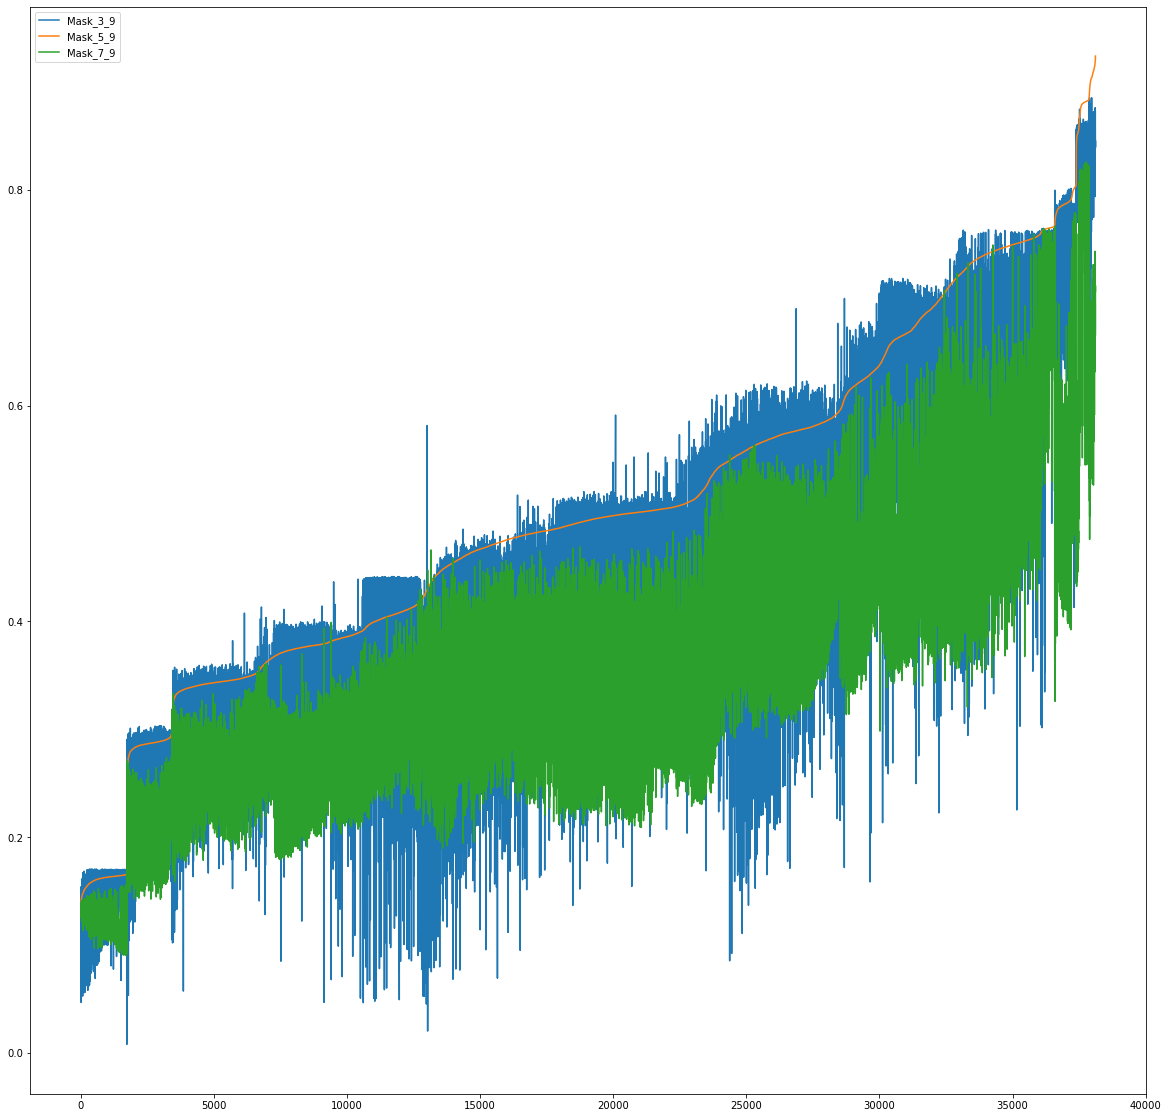

In [ ]:
#sort acc
acc.sort(key=lambda x: x[1])

#plot acc as a line graph with the x-axis being the number of iterations and the y-axis being the accuracy
plt.figure(figsize=(20, 20))
plt.plot(np.arange(len(acc)), np.array(acc)[:,0], label="Mask_3_9")
plt.plot(np.arange(len(acc)), np.array(acc)[:,1], label="Mask_5_9")
plt.plot(np.arange(len(acc)), np.array(acc)[:,2], label="Mask_7_9")
plt.legend()
plt.show()

In [ ]:
#save acc as a csv file
np.savetxt("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\Thesis\\dataset\\acc.csv", np.array(acc), delimiter=",")